In [1]:
# import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import os 

In [2]:
# Load the prepared data
path = r'C:\Users\HP\Anaconda Scripts\My Course\Personal Projects\Exploratory Data Analysis of Movie Trends'

prepared_data_path = os.path.join(path, '02 Data', 'Prepared Data', 'movies_data.csv')
movies_data_clean = pd.read_csv(prepared_data_path)

In [3]:
BILLION = 1_000_000_000
MIN_MOVIES = 5
MAX_ROI_CLIP = 1000

In [4]:
# SAFE PARSING

def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x if isinstance(x, list) else []

movies_data_clean["production_countries"] = movies_data_clean["production_countries"].apply(safe_literal_eval)

In [5]:
# GET COUNTRY NAMES

def get_country_names(country_list):
    if isinstance(country_list, list):
        return [
            c.get("name")
            for c in country_list
            if isinstance(c, dict) and c.get("name")
        ]
    return []

movies_data_clean["country_names"] = movies_data_clean["production_countries"].apply(get_country_names)

In [6]:
# EXPLODE

country_data = movies_data_clean.explode("country_names")

country_data_valid = country_data.dropna(
    subset=["revenue", "ROI", "vote_average", "country_names"]
).copy()

In [7]:
# Clip ROI outliers safely – no SettingWithCopyWarning
country_data_valid.loc[:, "ROI"] = country_data_valid["ROI"].clip(upper=MAX_ROI_CLIP)

In [8]:
# GROUP BY COUNTRY

country_stats = country_data_valid.groupby("country_names").agg(
    total_revenue=("revenue", "sum"),
    median_roi=("ROI", "median"),
    average_rating=("vote_average", "mean"),
    movie_count=("original_title", "count")
).reset_index()

country_stats_filtered = country_stats[country_stats["movie_count"] >= MIN_MOVIES]

In [9]:
# LABEL FUNCTION
def add_labels(ax, values, fmt="{:.2f}"):
    """Attach numeric labels to horizontal bars."""
    for i, v in enumerate(values):
        ax.text(
            v + (v * 0.01) + 0.05,
            i,
            fmt.format(v),
            va="center",
            fontsize=10
        )

## 1. TOTAL REVENUE

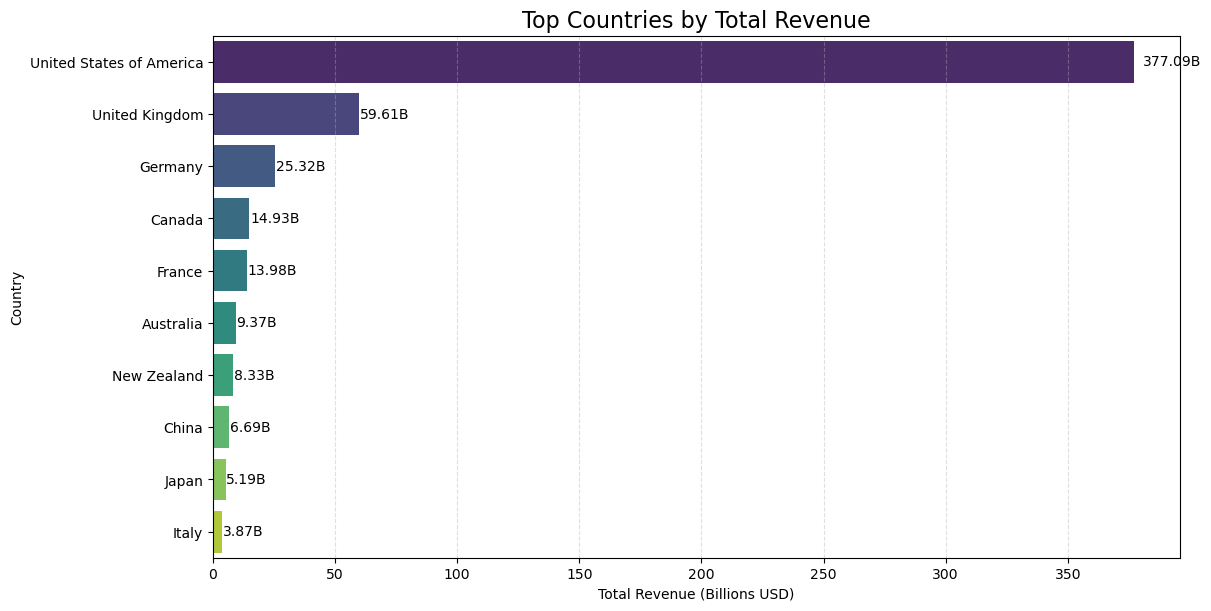

In [10]:
top_revenue = country_stats_filtered.nlargest(10, "total_revenue")

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

# Convert to billions for plotting
top_revenue["revenue_billions"] = top_revenue["total_revenue"] / BILLION

sns.barplot(
    data=top_revenue,
    x="revenue_billions",
    y="country_names",
    hue="country_names",
    legend=False,
    palette="viridis",
    ax=ax
)

ax.set_title("Top Countries by Total Revenue", fontsize=16)
ax.set_xlabel("Total Revenue (Billions USD)")
ax.set_ylabel("Country")

# --- Add revenue labels → e.g., 12.57 ---
add_labels(ax, top_revenue["revenue_billions"], fmt="{:.2f}B")

ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()


## 2. MEDIAN ROI

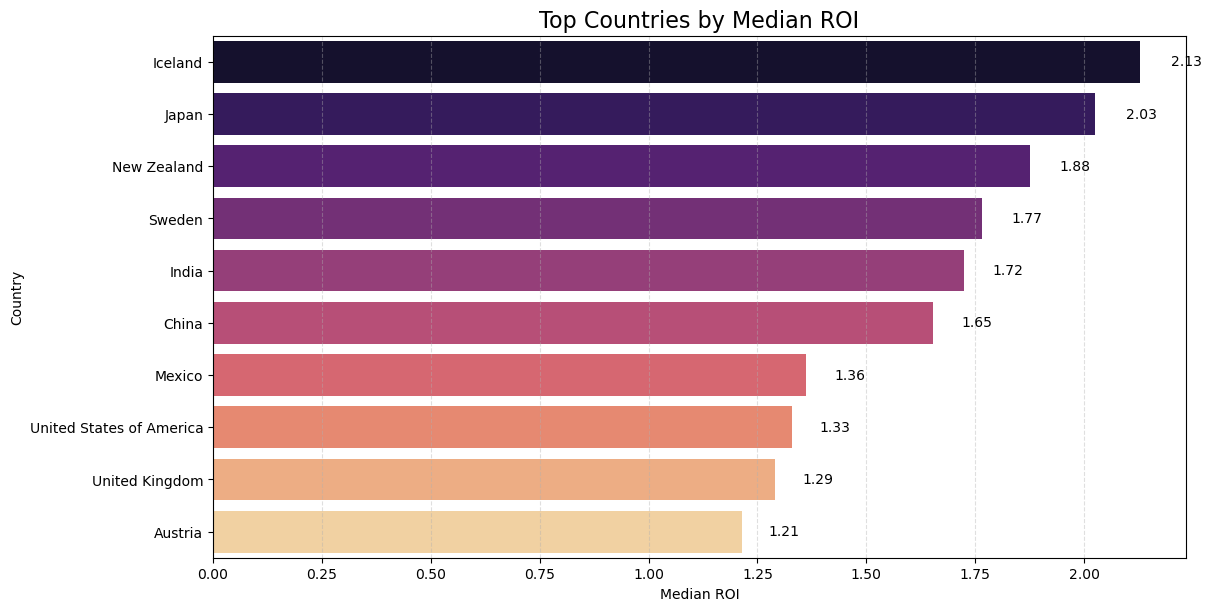

In [11]:
top_roi = country_stats_filtered.nlargest(10, "median_roi")

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

sns.barplot(
    data=top_roi,
    x="median_roi",
    y="country_names",
    hue="country_names",
    legend=False,
    palette="magma",
    ax=ax
)

ax.set_title("Top Countries by Median ROI", fontsize=16)
ax.set_xlabel("Median ROI")
ax.set_ylabel("Country")

# Add labels
add_labels(ax, top_roi["median_roi"], fmt="{:.2f}")

ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()

## 3. AVERAGE RATING

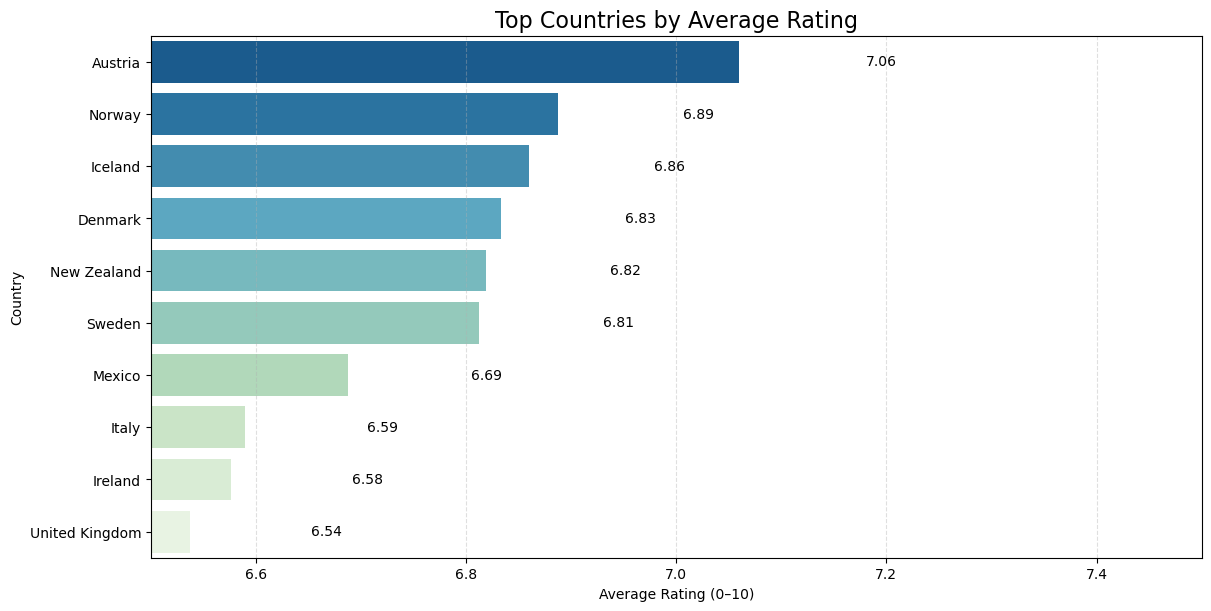

In [12]:
top_rating = country_stats_filtered.nlargest(10, "average_rating")

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

sns.barplot(
    data=top_rating,
    x="average_rating",
    y="country_names",
    hue="country_names",
    legend=False,
    palette="GnBu_r",
    ax=ax
)

ax.set_title("Top Countries by Average Rating", fontsize=16)
ax.set_xlabel("Average Rating (0–10)")
ax.set_ylabel("Country")

ax.set_xlim(6.5, 7.5)

# Add rating labels
add_labels(ax, top_rating["average_rating"], fmt="{:.2f}")

ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()